# Bank Churn Prediction

### Brandon Lotus
#### - _Machine Learning_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Data Preprocessing

In [5]:
df = pd.read_csv('bank.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Rencana untuk beberapa features sebelum masuk ke machine learning:

- RowNumber --> drop (tidak berhubungan dengan tujuan machine learning)

- CustomerId --> drop (tidak berhubungan dengan tujuan machine learning)

- Surname --> drop (tidak berhubungan dengan tujuan machine learning)

- Geography --> One hot encoding (encoding karena ML hanya menerima numerik, one hot karena Geography merupakan kategori data yg bersifat Nominal atau tidak memiliki tingkatan/urutan)

- Gender --> Label encoding (encoding karena ML hanya menerima numerik, label karena Gender merupakan data binary

Data target Exited tidak balance 20:80
- Model akan kesulitan menebak data kelas minority (Exited 1), akan ada banyak salah prediksi di kelas minority
- Padahal prediksi di kelas minority adalah Goals ML ini
- Melakukan imbalance handling dengan SMOTE

Scaling
- Untuk menyamakan skala antar features
- Digunakan pada algoritma berbasis distance, tidak berpengaruh pada algoritma tree based
- Melakukan scaling dengan robust scaler (karena ada outliers)

### Feature Selection & Feature Engineering

In [6]:
# Drop kolom RowNumber, CustomerId dan Surname karena tidak berhubungan dengan tujuan machine learning
df = df.drop(['RowNumber','CustomerId','Surname'], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
# Melihat variasi data Geography
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [8]:
# Mengubah Geography menjadi numerik dengan get dummies (one hot encoding)
df = pd.get_dummies(data=df, columns=['Geography'])
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,Female,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,Female,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,Female,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,Female,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,Female,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [9]:
# Mengubah Gender menjadi numerik (label encoding)
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,1,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,1,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,1,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,1,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,1,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [10]:
# Melihat korelasi features dengan target Exited
kor = df.corr()
kor['Exited'].sort_values(ascending = False)[1:]
# Feature dengan korelasi tertinggi adalah Age
# Feature EstimatedSalary, HasCrCard dan Tenure memiliki korelasi terendah (<0.02)

Age                  0.285323
Geography_Germany    0.173488
Balance              0.118533
Gender               0.106512
EstimatedSalary      0.012097
HasCrCard           -0.007138
Tenure              -0.014001
CreditScore         -0.027094
NumOfProducts       -0.047820
Geography_Spain     -0.052667
Geography_France    -0.104955
IsActiveMember      -0.156128
Name: Exited, dtype: float64

In [11]:
# Drop kolom EstimatedSalary, HasCrCard dan Tenure karena korelasi kecil dengan kolom target Exited (<0.02)
df = df.drop(['EstimatedSalary','HasCrCard','Tenure'], axis=1)
df.head()

,CreditScore,Gender,Age,Balance,NumOfProducts,IsActiveMember,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,1,42,0.00,1,1,1,1,0,0
1,608,1,41,83807.86,1,1,0,0,0,1
2,502,1,42,159660.80,3,0,1,1,0,0
3,699,1,39,0.00,2,0,0,1,0,0
4,850,1,43,125510.82,1,1,0,0,0,1


In [12]:
# Define x (features) dan y (target)
X = df.drop(columns='Exited')
y = df['Exited']

#### Spliting Data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, train_size = .8, random_state=42)

#### SMOTE
Membuat data sintetis untuk imbalance handling dari kelas 1 (minority) hingga jumlahnya sama dengan kelas 0 (majority)

In [14]:
import imblearn
from imblearn.over_sampling import SMOTE

In [15]:
sm = SMOTE(random_state=42)

In [16]:
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

In [17]:
df_smote = pd.concat([X_train_sm, y_train_sm], axis = 1)
df_smote['Exited'].value_counts()
# Data pada kolom target sudah seimbang

1    6370
0    6370
Name: Exited, dtype: int64

In [18]:
X_train_sm.head()

,CreditScore,Gender,Age,Balance,NumOfProducts,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain
0,753,0,57,0.00,1,0,1,0,0
1,739,0,32,102128.27,1,0,0,1,0
2,755,1,37,113865.23,2,1,0,1,0
3,561,0,37,0.00,2,0,1,0,0
4,692,0,49,110540.43,2,1,0,1,0


### Machine Learning Modelling

#### Logistic Regression (Base)

In [19]:
logreg_base =LogisticRegression()
logreg_base.fit(X_train_sm, y_train_sm)
y_pred_logreg_base = logreg_base.predict(X_test)
y_pred_logreg_base_train = logreg_base.predict(X_train_sm)

In [20]:
recall_logreg_base = recall_score(y_test, y_pred_logreg_base)
acc_logreg_base = accuracy_score(y_test, y_pred_logreg_base)
precision_logreg_base = precision_score(y_test, y_pred_logreg_base)
f1_logreg_base = f1_score(y_test, y_pred_logreg_base)
recall_logreg_base_train = recall_score(y_train_sm, y_pred_logreg_base_train)

In [21]:
# Hasil recall untuk train dan test logreg base
print(f"Train recall logreg base: {recall_logreg_base_train}")
print(f"Test recall logreg base: {recall_logreg_base}")

Train recall logreg base: 0.685243328100471
Test recall logreg base: 0.683046683046683


In [22]:
print(classification_report(y_test, y_pred_logreg_base))

              precision    recall  f1-score   support

           0       0.89      0.63      0.74      1593
           1       0.32      0.68      0.44       407

    accuracy                           0.64      2000
   macro avg       0.60      0.66      0.59      2000
weighted avg       0.77      0.64      0.68      2000



In [23]:
cm_logreg_base = confusion_matrix(y_test, y_pred_logreg_base, labels = [1,0])
df_logreg_base = pd.DataFrame(data = cm_logreg_base, index = ['aktual 1', 'aktual 0'], columns = ['Prediksi 1', 'Prediksi 0'])
df_logreg_base

,Prediksi 1,Prediksi 0
aktual 1,278,129
aktual 0,585,1008


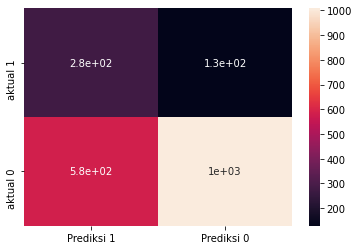

In [24]:
sns.heatmap(df_logreg_base, annot = True)

- Evaluation metrics yang akan difokuskan adalah recall karena yang ingin dihindari adalah nasabah yang pindah namun diprediksi tidak pindah (Prediksi 0 Aktual 1) / false negative
- Jumlah untuk false negative pada model logreg base ini 129
- Nilai recall untuk train (0.685) dan test (0.683) cukup baik (masih dapat ditingkatkan)

#### KNN (Base)

In [25]:
KNN_base = KNeighborsClassifier()
KNN_base.fit(X_train_sm, y_train_sm)
y_pred_KNN_base = KNN_base.predict(X_test)
y_pred_KNN_base_train = KNN_base.predict(X_train_sm)

In [26]:
recall_KNN_base = recall_score(y_test, y_pred_KNN_base)
acc_KNN_base = accuracy_score(y_test, y_pred_KNN_base)
precision_KNN_base = precision_score(y_test, y_pred_KNN_base)
f1_KNN_base = f1_score(y_test, y_pred_KNN_base)
recall_KNN_base_train = recall_score(y_train_sm, y_pred_KNN_base_train)

In [27]:
print(f"Train recall KNN base: {recall_KNN_base_train}")
print(f"Test recall KNN base: {recall_KNN_base}")

Train recall KNN base: 0.8979591836734694
Test recall KNN base: 0.44963144963144963


In [28]:
print(classification_report(y_test, y_pred_KNN_base))

              precision    recall  f1-score   support

           0       0.81      0.62      0.70      1593
           1       0.23      0.45      0.31       407

    accuracy                           0.58      2000
   macro avg       0.52      0.53      0.50      2000
weighted avg       0.70      0.58      0.62      2000



In [29]:
cm_KNN_base = confusion_matrix(y_test, y_pred_KNN_base, labels = [1,0])
df_KNN_base = pd.DataFrame(data = cm_KNN_base, index = ['aktual 1', 'aktual 0'], columns = ['Prediksi 1', 'Prediksi 0'])
df_KNN_base

,Prediksi 1,Prediksi 0
aktual 1,183,224
aktual 0,609,984


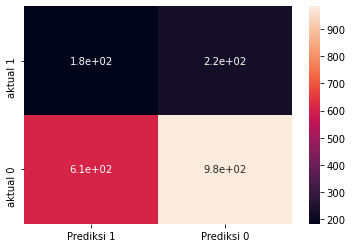

In [30]:
sns.heatmap(df_KNN_base, annot = True)

- Evaluation metrics yang akan difokuskan adalah recall karena yang ingin dihindari adalah nasabah yang pindah namun diprediksi tidak pindah (Prediksi 0 Aktual 1) / false negative
- Jumlah untuk false negative pada model KNN base ini 224 (lebih buruk dari logreg base)
- Nilai recall untuk train (0.898) dan test (0.449) overfit dan kurang baik (dibawah 0.5 / coin toss)

#### Decision Tree (Base)

In [31]:
DT_base =DecisionTreeClassifier()
DT_base.fit(X_train_sm, y_train_sm)
y_pred_DT_base = DT_base.predict(X_test)
y_pred_DT_base_train = DT_base.predict(X_train_sm)

In [32]:
recall_DT_base = recall_score(y_test, y_pred_DT_base)
acc_DT_base = accuracy_score(y_test, y_pred_DT_base)
precision_DT_base = precision_score(y_test, y_pred_DT_base)
f1_DT_base = f1_score(y_test, y_pred_DT_base)
recall_DT_base_train = recall_score(y_train_sm, y_pred_DT_base_train)

In [33]:
print(f"Train recall DT base: {recall_DT_base_train}")
print(f"Test recall DT base: {recall_DT_base}")

Train recall DT base: 0.9990580847723705
Test recall DT base: 0.5651105651105651


In [34]:
print(classification_report(y_test, y_pred_DT_base))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1593
           1       0.45      0.57      0.50       407

    accuracy                           0.77      2000
   macro avg       0.66      0.69      0.67      2000
weighted avg       0.79      0.77      0.78      2000



In [35]:
cm_DT_base = confusion_matrix(y_test, y_pred_DT_base, labels = [1,0])
df_DT_base = pd.DataFrame(data = cm_DT_base, index = ['aktual 1', 'aktual 0'], columns = ['Prediksi 1', 'Prediksi 0'])
df_DT_base

,Prediksi 1,Prediksi 0
aktual 1,230,177
aktual 0,286,1307


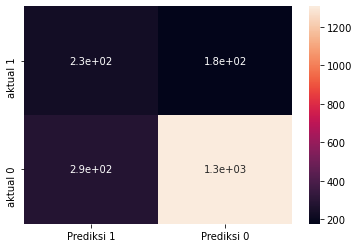

In [36]:
sns.heatmap(df_DT_base, annot =True )

- Evaluation metrics yang akan difokuskan adalah recall karena yang ingin dihindari adalah nasabah yang pindah namun diprediksi tidak pindah (Prediksi 0 Aktual 1) / false negative
- Jumlah untuk false negative pada model decision tree base ini 177 (lebih buruk dari logreg base, lebih baik dari KNN base)
- Nilai recall untuk train (0.999) dan test (0.565) overfit dan masih dapat ditingkatkan

### Scaling (Robust Scaler)

In [37]:
from sklearn.preprocessing import RobustScaler

In [38]:
robust_scaler = RobustScaler()
X_train_scaled = robust_scaler.fit_transform(X_train_sm)
X_test_scaled = robust_scaler.fit_transform(X_test)

#### Logistic Regression (Scaled)

In [39]:
logreg_scaled =LogisticRegression()
logreg_scaled.fit(X_train_scaled, y_train_sm)
y_pred_logreg_scaled = logreg_scaled.predict(X_test_scaled)
y_pred_logreg_scaled_train = logreg_scaled.predict(X_train_scaled)

In [40]:
recall_logreg_scaled = recall_score(y_test, y_pred_logreg_scaled)
acc_logreg_scaled = accuracy_score(y_test, y_pred_logreg_scaled)
precision_logreg_scaled = precision_score(y_test, y_pred_logreg_scaled)
f1_logreg_scaled = f1_score(y_test, y_pred_logreg_scaled)
recall_logreg_scaled_train = recall_score(y_train_sm, y_pred_logreg_scaled_train)

In [41]:
print(f"Train recall logreg scaled: {recall_logreg_scaled_train}")
print(f"Test recall logreg scaled: {recall_logreg_scaled}")

Train recall logreg scaled: 0.765149136577708
Test recall logreg scaled: 1.0


In [42]:
print(classification_report(y_test, y_pred_logreg_scaled))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1593
           1       0.20      1.00      0.34       407

    accuracy                           0.20      2000
   macro avg       0.10      0.50      0.17      2000
weighted avg       0.04      0.20      0.07      2000



In [43]:
cm_logreg_scaled = confusion_matrix(y_test, y_pred_logreg_scaled, labels = [1,0])
df_logreg_scaled = pd.DataFrame(data = cm_logreg_scaled, index = ['aktual 1', 'aktual 0'], columns = ['Prediksi 1', 'Prediksi 0'])
df_logreg_scaled

,Prediksi 1,Prediksi 0
aktual 1,407,0
aktual 0,1593,0


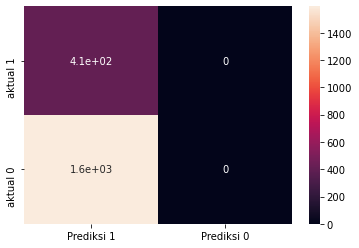

In [44]:
sns.heatmap(df_logreg_scaled, annot = True)

- Evaluation metrics yang akan difokuskan adalah recall karena yang ingin dihindari adalah nasabah yang pindah namun diprediksi tidak pindah (Prediksi 0 Aktual 1) / false negative
- Jumlah untuk false negative pada model logreg scaled ini 0, namun (Prediksi 1 Aktual 0) banyak (1593)
- Nilai recall untuk train (0.76) dan test (1.00), model hanya bagus pada nilai recall (tidak dapat dipakai)

#### KNN (Scaled)

In [45]:
KNN_scaled = KNeighborsClassifier()
KNN_scaled.fit(X_train_scaled, y_train_sm)
y_pred_KNN_scaled = KNN_scaled.predict(X_test_scaled)
y_pred_KNN_scaled_train = KNN_scaled.predict(X_train_scaled)

In [46]:
recall_KNN_scaled = recall_score(y_test, y_pred_KNN_scaled)
acc_KNN_scaled = accuracy_score(y_test, y_pred_KNN_scaled)
precision_KNN_scaled = precision_score(y_test, y_pred_KNN_scaled)
f1_KNN_scaled = f1_score(y_test, y_pred_KNN_scaled)
recall_KNN_scaled_train = recall_score(y_train_sm, y_pred_KNN_scaled_train)

In [47]:
print(f"Train recall KNN scaled: {recall_KNN_scaled_train}")
print(f"Test recall KNN scaled: {recall_KNN_scaled}")

Train recall KNN scaled: 0.8850863422291994
Test recall KNN scaled: 0.9041769041769042


In [48]:
print(classification_report(y_test, y_pred_KNN_scaled))

              precision    recall  f1-score   support

           0       0.92      0.30      0.45      1593
           1       0.25      0.90      0.39       407

    accuracy                           0.42      2000
   macro avg       0.59      0.60      0.42      2000
weighted avg       0.79      0.42      0.44      2000



In [49]:
cm_KNN_scaled = confusion_matrix(y_test, y_pred_KNN_scaled, labels = [1,0])
df_KNN_scaled = pd.DataFrame(data = cm_KNN_scaled, index = ['aktual 1', 'aktual 0'], columns = ['Prediksi 1', 'Prediksi 0'])
df_KNN_scaled

,Prediksi 1,Prediksi 0
aktual 1,368,39
aktual 0,1113,480


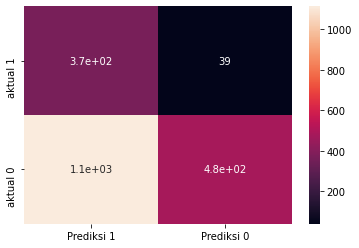

In [50]:
sns.heatmap(df_KNN_scaled, annot = True)

- Evaluation metrics yang akan difokuskan adalah recall karena yang ingin dihindari adalah nasabah yang pindah namun diprediksi tidak pindah (Prediksi 0 Aktual 1) / false negative
- Jumlah untuk false negative pada model KNN scaled ini 39 (jauh lebih baik dari KNN base)
- Nilai recall untuk train (0.885) dan test (0.904) sudah cukup baik

#### Model Decision Tree tidak dilakukan scaling karena tidak berlaku pada model tree based

### Hyperparameter Tuning

#### Logistic Regression (Hyperparameter Tuning)

In [63]:
logreg_tuning = LogisticRegression()
param_logreg = {'C': [1, 0.1, 0.5, 5, 10],
               'penalty':['l2','l1', 'elasticnet']}

model_logreg_tuned = GridSearchCV(estimator = logreg_tuning, param_grid = param_logreg, cv = 5, n_jobs = -1 , verbose = 1, scoring = 'recall')
model_logreg_tuned.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  75 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.4s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 0.1, 0.5, 5, 10],
                         'penalty': ['l2', 'l1', 'elasticnet']},
             scoring='recall', verbose=1)

In [64]:
logreg_tuned = model_logreg_tuned.best_estimator_
y_pred_logreg_tuned = logreg_tuned.predict(X_test)
y_pred_logreg_train_tuned = logreg_tuned.predict(X_train_sm)

In [65]:
recall_logreg_tuned = recall_score(y_test, y_pred_logreg_tuned)
acc_logreg_tuned = accuracy_score(y_test, y_pred_logreg_tuned)
precision_logreg_tuned = precision_score(y_test, y_pred_logreg_tuned)
f1_logreg_tuned = f1_score(y_test, y_pred_logreg_tuned)
recall_logreg_train_tuned = recall_score(y_train_sm, y_pred_logreg_train_tuned)

In [66]:
print(f"Train recall logreg tuned: {recall_logreg_train_tuned}")
print(f"Test recall logreg tuned: {recall_logreg_tuned}")

Train recall logreg tuned: 0.685243328100471
Test recall logreg tuned: 0.683046683046683


In [67]:
print(classification_report(y_test, y_pred_logreg_tuned))

              precision    recall  f1-score   support

           0       0.89      0.63      0.74      1593
           1       0.32      0.68      0.44       407

    accuracy                           0.64      2000
   macro avg       0.60      0.66      0.59      2000
weighted avg       0.77      0.64      0.68      2000



In [68]:
cm_logreg_tuned = confusion_matrix(y_test, y_pred_logreg_tuned, labels = [1,0])
df_logreg_tuned = pd.DataFrame(data = cm_logreg_tuned, index = ['aktual 1', 'aktual 0'], columns = ['Prediksi 1', 'Prediksi 0'])
df_logreg_tuned

,Prediksi 1,Prediksi 0
aktual 1,278,129
aktual 0,585,1008


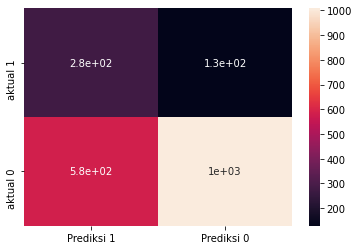

In [69]:
sns.heatmap(df_logreg_tuned, annot =True)

- Evaluation metrics yang akan difokuskan adalah recall karena yang ingin dihindari adalah nasabah yang pindah namun diprediksi tidak pindah (Prediksi 0 Aktual 1) / false negative
- Jumlah untuk false negative pada model logreg tuned ini 129 (tidak ada perubahan dengan model logreg base)
- Nilai recall untuk train (0.685) dan test (0.683) tidak berbeda dengan logreg base

#### KNN (Hyperparameter Tuning)

In [104]:
KNN_tuning = KNeighborsClassifier()
param_KNN = {"n_neighbors" : [5, 15, 25, 35, 75],
            "weights" : ["uniform", "distance"],
            "p" : [1,2]}

In [105]:
model_KNN_tuned = GridSearchCV(estimator = KNN_tuning, param_grid = param_KNN, cv = 3, n_jobs = -1 , verbose = 1, scoring = 'recall')

In [106]:
model_KNN_tuned.fit(X_train_sm, y_train_sm)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  60 | elapsed:    1.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.1s finished


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 15, 25, 35, 75], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='recall', verbose=1)

In [165]:
KNN_tuned = model_KNN_tuned.best_estimator_
y_tuned_KNN = KNN_tuned.predict(X_test)
y_tuned_KNN_train = KNN_tuned.predict(X_train_sm)

In [166]:
acc_KNN_tuned = accuracy_score(y_test, y_tuned_KNN)
prec_KNN_tuned = precision_score(y_test, y_tuned_KNN)
rec_KNN_tuned = recall_score(y_test, y_tuned_KNN)
f1_KNN_tuned = f1_score(y_test,y_tuned_KNN)

print(classification_report(y_test, y_tuned_KNN))

              precision    recall  f1-score   support

           0       0.82      0.66      0.73      1593
           1       0.25      0.45      0.32       407

    accuracy                           0.62      2000
   macro avg       0.54      0.56      0.53      2000
weighted avg       0.71      0.62      0.65      2000



In [109]:
df_KNN_tuned = pd.DataFrame(data = cm_KNN_tuned , index = ["Aktual 1","Aktual 0"], columns = ["Prediksi 1", "Prediksi 0"])
df_KNN_tuned

,Prediksi 1,Prediksi 0
Aktual 1,183,224
Aktual 0,538,1055


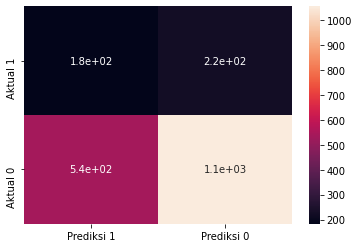

In [110]:
sns.heatmap(df_KNN_tuned, annot = True)

- Evaluation metrics yang akan difokuskan adalah recall karena yang ingin dihindari adalah nasabah yang pindah namun diprediksi tidak pindah (Prediksi 0 Aktual 1) / false negative
- Jumlah untuk false negative pada model KNN tuned ini 224 dan nilai recall 0.45 (sama dengan KNN base)

#### Decision Tree (Hyperparameter Tuning)

In [142]:
DT_tuning = DecisionTreeClassifier()
param_DT ={"max_depth" : [None, 5, 7, 9, 20, 25],
          "min_samples_split" : [2, 9, 15, 25],
          "min_samples_leaf" : [1, 2, 5, 10],
          "max_features" : [None, .8, .7, .6]}

In [143]:
model_DT_tuned = GridSearchCV(estimator = DT_tuning, param_grid = param_DT, cv = 5, n_jobs = -1 , verbose = 1, scoring = 'recall')

In [144]:
model_DT_tuned.fit(X_train_sm,y_train_sm)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:   23.2s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 7, 9, 20, 25],
                         'max_features': [None, 0.8, 0.7, 0.6],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 9, 15, 25]},
             scoring='recall', verbose=1)

In [145]:
DT_tuned = model_DT_tuned.best_estimator_

In [146]:
y_tuned_DT = DT_tuned.predict(X_test)

In [148]:
acc_DT_tuned = accuracy_score(y_test, y_tuned_DT)
prec_DT_tuned = precision_score(y_test, y_tuned_DT)
rec_DT_tuned = recall_score(y_test, y_tuned_DT)
f1_DT_tuned = f1_score(y_test,y_tuned_DT)

print(classification_report(y_test, y_tuned_DT))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1593
           1       0.45      0.58      0.51       407

    accuracy                           0.77      2000
   macro avg       0.67      0.70      0.68      2000
weighted avg       0.80      0.77      0.78      2000



In [149]:
df_DT_tuned = pd.DataFrame(data = cm_DT_tuned , index = ["Aktual 1","Aktual 0"], columns = ["Prediksi 1", "Prediksi 0"])
df_DT_tuned

,Prediksi 1,Prediksi 0
Aktual 1,237,170
Aktual 0,291,1302


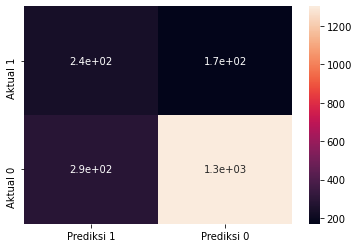

In [150]:
sns.heatmap(df_DT_tuned, annot = True)

- Evaluation metrics yang akan difokuskan adalah recall karena yang ingin dihindari adalah nasabah yang pindah namun diprediksi tidak pindah (Prediksi 0 Aktual 1) / false negative
- Jumlah untuk false negative pada model decision tree tuned ini 170 dan nilai recall 0.58 (meningkat sedikit dari DT base)

### Perbandingan Seluruh Model

In [151]:
# Logistic Regression Base Model
print(classification_report(y_test, y_pred_logreg_base))
df_logreg_base

              precision    recall  f1-score   support

           0       0.89      0.63      0.74      1593
           1       0.32      0.68      0.44       407

    accuracy                           0.64      2000
   macro avg       0.60      0.66      0.59      2000
weighted avg       0.77      0.64      0.68      2000



,Prediksi 1,Prediksi 0
aktual 1,278,129
aktual 0,585,1008


In [152]:
# KNN Base Model
print(classification_report(y_test, y_pred_KNN_base))
df_KNN_base

              precision    recall  f1-score   support

           0       0.81      0.62      0.70      1593
           1       0.23      0.45      0.31       407

    accuracy                           0.58      2000
   macro avg       0.52      0.53      0.50      2000
weighted avg       0.70      0.58      0.62      2000



,Prediksi 1,Prediksi 0
aktual 1,183,224
aktual 0,609,984


In [153]:
# Decision Tree Base Model
print(classification_report(y_test, y_pred_DT_base))
df_DT_base

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1593
           1       0.45      0.57      0.50       407

    accuracy                           0.77      2000
   macro avg       0.66      0.69      0.67      2000
weighted avg       0.79      0.77      0.78      2000



,Prediksi 1,Prediksi 0
aktual 1,230,177
aktual 0,286,1307


In [154]:
# Logistic Regression Scaled
print(classification_report(y_test, y_pred_logreg_scaled))
df_logreg_scaled

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1593
           1       0.20      1.00      0.34       407

    accuracy                           0.20      2000
   macro avg       0.10      0.50      0.17      2000
weighted avg       0.04      0.20      0.07      2000



,Prediksi 1,Prediksi 0
aktual 1,407,0
aktual 0,1593,0


In [155]:
# KNN Scaled
print(classification_report(y_test, y_pred_KNN_scaled))
df_KNN_scaled

              precision    recall  f1-score   support

           0       0.92      0.30      0.45      1593
           1       0.25      0.90      0.39       407

    accuracy                           0.42      2000
   macro avg       0.59      0.60      0.42      2000
weighted avg       0.79      0.42      0.44      2000



,Prediksi 1,Prediksi 0
aktual 1,368,39
aktual 0,1113,480


In [156]:
# Logistic Regression Tuned
print(classification_report(y_test, y_pred_logreg_tuned))
df_logreg_tuned

              precision    recall  f1-score   support

           0       0.89      0.63      0.74      1593
           1       0.32      0.68      0.44       407

    accuracy                           0.64      2000
   macro avg       0.60      0.66      0.59      2000
weighted avg       0.77      0.64      0.68      2000



,Prediksi 1,Prediksi 0
aktual 1,278,129
aktual 0,585,1008


In [157]:
# KNN Tuned
print(classification_report(y_test, y_tuned_KNN))
df_KNN_tuned

              precision    recall  f1-score   support

           0       0.82      0.66      0.73      1593
           1       0.25      0.45      0.32       407

    accuracy                           0.62      2000
   macro avg       0.54      0.56      0.53      2000
weighted avg       0.71      0.62      0.65      2000



,Prediksi 1,Prediksi 0
Aktual 1,183,224
Aktual 0,538,1055


In [158]:
# Decision Tree Tuned
print(classification_report(y_test, y_tuned_DT))
df_DT_tuned

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1593
           1       0.45      0.58      0.51       407

    accuracy                           0.77      2000
   macro avg       0.67      0.70      0.68      2000
weighted avg       0.80      0.77      0.78      2000



,Prediksi 1,Prediksi 0
Aktual 1,237,170
Aktual 0,291,1302


In [167]:
# Evaluation metrics difokuskan pada nilai recall (menghindari nasabah yang pindah namun diprediksi tidak pindah / false negative)
# Dari perbandingan kedelapan model, yang terbaik adalah KNN Scaled dengan nilai recall tertinggi 0.9 dan nilai false negative terendah 39
# Export Model
import joblib
joblib.dump(KNN_scaled, 'ModelBank')

['ModelBank']

### Kesimpulan

- Dari dataset 20% customer pindah bank
- Customer yang pindah cenderung berada dalam kategori usia yang lebih tua
- Customer wanita lebih cenderung pindah bank daripada pria
    - wanita (25% pindah)
    - pria (16% pindah)
- Customer dari Germany lebih kemungkinan pindah dibanding France dan Spain
    - Germany (32% pindah)
    - Spain (17% pindah)
    - France (16% pindah)
- Jumlah produk customer mempengaruhi pindahnya customer
    - customer yang memiliki 3-4 produk cenderung pindah
    - customer yang memiliki 1-2 produk cenderung bertahan
- Kepemilikan kartu kredit tidak mempengaruhi pindahnya customer
    - customer yang memiliki kartu kredit (20% pindah)
    - customer yang tidak memiliki kartu kredit (21% pindah)
- Member aktif mempengaruhi pindahnya customer
    - customer yang member aktif (14% pindah)
    - customer yang bukan member aktif (27% pindah)
- Dari kedelapan model, model terbaik adalah KNN Scaled dengan jumlah false negative 39 dan nilai recall 0.9

### Saran

- Bank dapat meningkatkan pendekatan kepada customer wanita dengan layanan-layanan yang dapat meningkatkan loyalitas customer wanita

- Bank dapat meningkatkan interaksi dengan customer agar lebih banyak customer menjadi member aktif. Hal ini dapat dilakukan melalui event / kegiatan maupun melalui aplikasi interaktif

- Bank dapat lebih gencar melakukan promosi di Perancis karena selain jumlah customer yang lebih banyak juga tingkat loyalitas yang lebih tinggi dibandingkan negara lain

- Bank dapat meninjau ulang produk-produk tambahan yang akan ditawarkan agar tidak mengurangi loyalitas customer karena berdasarkan hasil analisa, customer yang memiliki lebih dari 2 produk justru cenderung pindah